В данном проекте на основе исторических данных объявлений о продаже автомобилей построены и проанализированы несколько моделей для предсказания рыночной стоимости автомобилей.

# 1. Подготовка данных

Первым шагом настроим окружение: импортируем все необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import time
from sklearn.preprocessing import OrdinalEncoder 

Сохраним в переменной autos входные исторические данные: технические характеристики, комплектации и цены автомобилей. Выведем первые 5 строк и просмотрим информацию о типах данных датасета.

In [2]:
autos = pd.read_csv('/datasets/autos.csv')

In [3]:
display(autos.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Приведем к нижнему регистру названия столбцов и просмотрим информацию о типах данных.

In [4]:
autos.columns = autos.columns.str.lower()

In [5]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
datecrawled          354369 non-null object
price                354369 non-null int64
vehicletype          316879 non-null object
registrationyear     354369 non-null int64
gearbox              334536 non-null object
power                354369 non-null int64
model                334664 non-null object
kilometer            354369 non-null int64
registrationmonth    354369 non-null int64
fueltype             321474 non-null object
brand                354369 non-null object
notrepaired          283215 non-null object
datecreated          354369 non-null object
numberofpictures     354369 non-null int64
postalcode           354369 non-null int64
lastseen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Проверим наличие дубликатов в данных и удалим их.

In [6]:
display(autos[autos.duplicated()])

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [7]:
autos = autos.drop_duplicates()

Удалим столбцы с данными, не влияющие на результат предсказания модели: DateCrawled — дата скачивания анкеты из базы; RegistrationMonth — месяц регистрации автомобиля; DateCreated — дата создания анкеты; NumberOfPictures — количество фотографий автомобиля; PostalCode — почтовый индекс владельца анкеты (пользователя); LastSeen — дата последней активности пользователя.

In [8]:
autos = autos.drop(['datecrawled', 'registrationmonth',
                   'datecreated', 'numberofpictures', 'postalcode', 'lastseen'], axis=1)

Просмотрим разброс данных с численными признаками. Построим для каждого столбца диаграмму размаха.

In [9]:
autos.describe()

,price,registrationyear,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


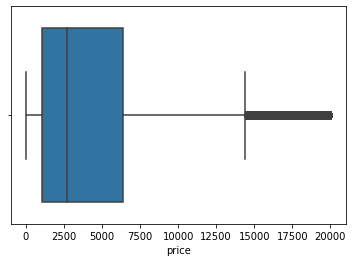

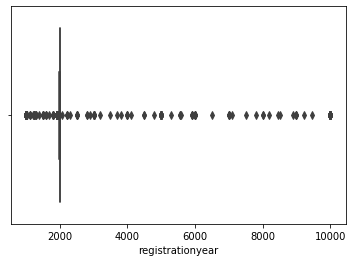

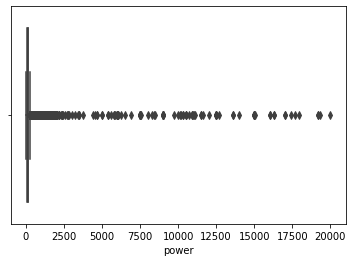

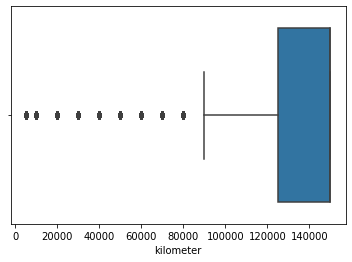

In [10]:
columns = ['price', 'registrationyear', 'power', 'kilometer']
for col in columns:
    sns.boxplot(autos[col])
    plt.show()

Дата создания анкеты приходится на весну 2016 года, тогда курс евро составлял 70-80 рублей, отбросим объявления с ценой автомобиля менее 400 евро, что соответствует ~ 30тыс.руб. Даже для разбитого автомобиля цены являются аномальными. Для остальных столбцов - RegistrationYear — год регистрации автомобиля; Power — мощность (л.с.) - обработаем аномальные значения на основе представленных диаграмм размаха. Построим диаграммы размаха после обработки данных. 

In [11]:
autos = autos.loc[(autos['price'] > 400) & (autos['price'] < 15000)]
autos = autos.loc[(autos['registrationyear'] > 1985) & (autos['registrationyear'] < 2017)]
autos = autos.loc[(autos['power'] > 30) & (autos['power'] < 250)]

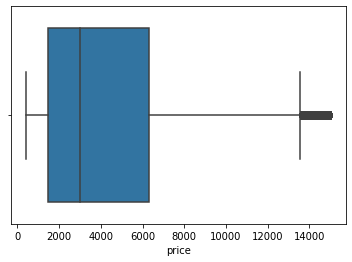

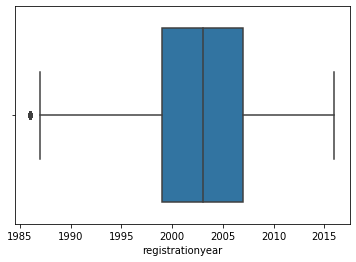

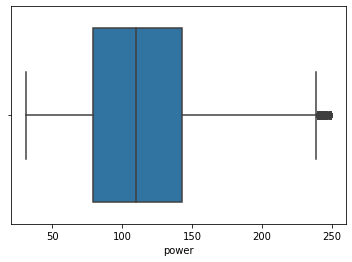

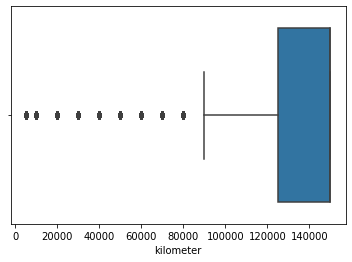

In [12]:
columns = ['price', 'registrationyear', 'power', 'kilometer']
for col in columns:
    sns.boxplot(autos[col])
    plt.show()

Определим количество и долю пропущенных значений в столбцах датасета.

In [13]:
Na_sum = autos.isna().sum()

In [14]:
NaN_fraction = Na_sum * 100 / len(autos)
missing_value_df = pd.DataFrame({'Доля пропущенных значений, %': NaN_fraction})
missing_value_df.sort_values('Доля пропущенных значений, %', inplace=True, ascending=False)
display(missing_value_df.round(decimals=2))

,"Доля пропущенных значений, %"
notrepaired,13.73
fueltype,4.77
model,3.29
vehicletype,3.21
gearbox,1.68
price,0.00
registrationyear,0.00
power,0.00
kilometer,0.00
brand,0.00


Удалим столбцы, в которых доля пропущенных значений составляет < 5%.

In [15]:
autos.dropna(subset=['fueltype', 'vehicletype', 'model', 'gearbox', 'notrepaired'], inplace=True)

Просмотрим информацию о данных после обработки.

In [16]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206243 entries, 3 to 354367
Data columns (total 10 columns):
price               206243 non-null int64
vehicletype         206243 non-null object
registrationyear    206243 non-null int64
gearbox             206243 non-null object
power               206243 non-null int64
model               206243 non-null object
kilometer           206243 non-null int64
fueltype            206243 non-null object
brand               206243 non-null object
notrepaired         206243 non-null object
dtypes: int64(4), object(6)
memory usage: 17.3+ MB


### Вывод
В предоставленном наборе данных имеется информация о более 350 тыс. объявлений о продаже автомобилей, которые характеризуются следующими признаками:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевым признаком является - Price — цена (евро)

Проведена предобработка данных:
1. Удалены столбцы:
DateCrawled — дата скачивания анкеты из базы; RegistrationMonth — месяц регистрации автомобиля; DateCreated — дата создания анкеты; NumberOfPictures — количество фотографий автомобиля; PostalCode — почтовый индекс владельца анкеты (пользователя); LastSeen — дата последней активности пользователя.
2. На основе построения диаграмм размаха, от аномальных значений отфильтрованы данные столбцов: цена; год регистрации; пробег(км) и мощность(л.с.) автомобиля.
3. Найдены и удалены дубликаты в данных.
4. Удалены объявления с пропущенными значениями.

# 2. Обучение моделей

Перед обучением моделей обработаем соответствующие признаки: преобразуем категориальные признаки в количественные, проведем масшиабирование количественных признаков. Рассмотрим несколько моделей для предсказаний стоимости автомобиля: модель линейной регрессии, случайного леса, решающего дерева и модель градиентного бустинга LGBMRegressor. Последняя работает с категориальными признаками напрямую, при обучении модели в аргументе будем передавать категориальные признаки, предварительно изменив тип данных "object" на "category". Для обучения остальных моделей приведем категориальные признаки к численным с помощью техники OHE.

In [17]:
autos_ohe = pd.get_dummies(autos, drop_first=True)
display(autos_ohe.head())

,price,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,...,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_yes
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6,2200,2004,109,150000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,2000,2004,105,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Запишем в переменных features и features_ohe признаки для обучения модели градиентного бустинга и остальных моделей, соответственно. В переменной target - целевой признак. Разделим данные на обучающую и валидационную выборки в соотношениие 3:1. Выведем размеры для обучающей и валидационной выборок после разделения данных.

In [18]:
features_ohe = autos_ohe.drop(['price'], axis = 1)
target = autos['price']

In [19]:
#закомментировал то ,что было
#features_train_ohe, features_valid_ohe, target_train, target_valid = train_test_split\
#(features_ohe, target, test_size=0.25, random_state=12345)

# выделим обучающую выборку
features_train_ohe, features_valid_test_ohe, target_train, target_valid_test =\
train_test_split(features_ohe, target, test_size=0.4, random_state=12345)

# разделим оставшиееся данные на валидационную и тестовую выборки
features_valid_ohe, features_test_ohe, target_valid, target_test = \
train_test_split(features_valid_test_ohe, target_valid_test, test_size=0.5, random_state=12345)

In [20]:
print(features_train_ohe.shape)
print(target_train.shape)
print(features_valid_ohe.shape)
print(target_valid.shape)
print(features_test_ohe.shape)
print(target_test.shape)

(123745, 300)
(123745,)
(41249, 300)
(41249,)
(41249, 300)
(41249,)


Создадим переменные с признаками для обучения модели градиентного бустинга.

In [21]:
features = autos.drop(['price'], axis = 1) 

In [22]:
categorical_columns = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

for col in categorical_columns:
    features[col] = features[col].astype('category')

In [23]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206243 entries, 3 to 354367
Data columns (total 9 columns):
vehicletype         206243 non-null category
registrationyear    206243 non-null int64
gearbox             206243 non-null category
power               206243 non-null int64
model               206243 non-null category
kilometer           206243 non-null int64
fueltype            206243 non-null category
brand               206243 non-null category
notrepaired         206243 non-null category
dtypes: category(6), int64(3)
memory usage: 7.7 MB


In [24]:
#было
#features_train, features_valid = train_test_split\
#(features, test_size=0.25, random_state=12345)

# выделим обучающую выборку
features_train, features_valid_test = train_test_split(features, test_size=0.4, random_state=12345)

# разделим оставшиееся данные на валидационную и тестовую выборки
features_valid, features_test = train_test_split(features_valid_test, test_size=0.5, random_state=12345)

In [25]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(123745, 9)
(41249, 9)
(41249, 9)


In [26]:
encoder = OrdinalEncoder()
features_ordinal = pd.DataFrame(encoder.fit_transform(features), columns=features.columns)

In [27]:
# выделим обучающую выборку
features_train_ordinal, features_valid_test_ordinal =\
train_test_split(features_ordinal, test_size=0.4, random_state=12345)

# разделим оставшиееся данные на валидационную и тестовую выборки
features_valid_ordinal, features_test_ordinal =\
train_test_split(features_valid_test_ordinal, test_size=0.5, random_state=12345)

In [28]:
print(features_train_ordinal.shape)
print(features_valid_ordinal.shape)
print(features_test_ordinal.shape)

(123745, 9)
(41249, 9)
(41249, 9)


Проведем масштабирование численных признаков для обучающей и валидационной выборок методом  стандартизации данных.

In [29]:
# выделим численные признаки
numeric = ['registrationyear', 'power', 'kilometer']

#настроим структуру для стандартизации на обучающих данных
scaler = StandardScaler()
scaler.fit(features_train[numeric])
# преобразуем выборки функцией transform()
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])
features_train_ordinal[numeric] = scaler.transform(features_train_ordinal[numeric])
features_valid_ordinal[numeric] = scaler.transform(features_valid_ordinal[numeric])
features_test_ordinal[numeric] = scaler.transform(features_test_ordinal[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# просмотрим данные после масштабирования
display(features_train_ohe.head())
display(features_train_ordinal.head())
display(features_train.head())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,...,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_yes
333569,-0.998239,-1.537217,0.596060,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
178707,-1.191312,-0.369814,0.596060,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
309931,1.125560,0.522907,-1.393253,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146954,0.932487,0.591577,-0.824878,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62848,0.932487,2.308347,0.596060,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
194146,5.0,-384.440516,1.0,-2.269706,173.0,-3.666412,6.0,37.0,0.0
103875,5.0,-384.633589,1.0,-1.102302,116.0,-3.666412,6.0,37.0,0.0
180325,0.0,-382.316717,1.0,-0.209582,244.0,-3.666526,6.0,24.0,0.0
85538,4.0,-382.509789,1.0,-0.140911,6.0,-3.666469,2.0,2.0,0.0
36568,7.0,-382.509789,0.0,1.575859,9.0,-3.666412,2.0,4.0,0.0


,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
333569,small,-0.998239,manual,-1.537217,polo,0.596060,petrol,volkswagen,no
178707,small,-1.191312,manual,-0.369814,golf,0.596060,petrol,volkswagen,no
309931,bus,1.125560,manual,0.522907,zafira,-1.393253,petrol,opel,no
146954,sedan,0.932487,manual,0.591577,1er,-0.824878,gasoline,bmw,no
62848,wagon,0.932487,auto,2.308347,300c,0.596060,gasoline,chrysler,no


Заказчику важны качество предсказания, скорость предсказания и время обучения. Обучим различные модели, рассчитаем метрику RMSE для предсказаний на валидационной выборке и определим скорость предсказания и время обучения. Создадим список results, в который будем сохранять интересующие заказчика параметры, для дальнейшего анализа моделей.

In [30]:
#results = []

#### 2.1. Модель линейной регрессии

In [31]:
start = time.time()
model = LinearRegression()
model.fit(features_train_ohe, target_train)
fit_time = time.time() - start

start = time.time()
predict_valid_ohe = model.predict(features_valid_ohe)
predict_time = time.time() - start

mse = mean_squared_error(target_valid, predict_valid_ohe)
print('RMSE модели:', mse**0.5)

#result_LR = fit_time, predict_time, mse**0.5

RMSE модели: 1822.0482843006107


In [32]:
#results.append(result_LR)

#### 2.2. Модель решающего дерева

Рассмотрим модель решающего дерева. При обучении модели проварьируем гиперпараметр -  глубину дерева. Cохраним модель с лучшим значением метрики accuracy на валидационной выборке.

In [33]:
best_result = 3000
best_depth = None
best_fit_time = None
best_predict_time = None
for depth in range(1, 11):
    start = time.time()
    model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    model.fit(features_train_ordinal, target_train)
    fit_time = time.time() - start
    
    start = time.time()
    predict_valid_ordinal = model.predict(features_valid_ordinal)
    predict_time = time.time() - start
    mse = mean_squared_error(target_valid, predict_valid_ordinal)
    result = mse**0.5
    if result < best_result:
        best_result = result
        best_depth = depth
        best_fit_time = fit_time
        best_predict_time = predict_time
    
print('RMSE модели при max_depth =', best_depth, 'составляет:', best_result)

#result_DTR = best_fit_time, best_predict_time, best_result

RMSE модели при max_depth = 10 составляет: 1573.4485392179595


#### 2.3. Модель случайного леса

In [35]:
#for est in range(10, 51, 10):
    #model = RandomForestRegressor(n_estimators=est, random_state=12345)
    #model.fit(features_train_ohe, target_train_ohe)
    #predict_valid_ohe = model.predict(features_valid_ohe)
    #mse = mean_squared_error(target_valid_ohe, predict_valid_ohe)
    #print('RMSE модели при n_estimators =', est, 'составляет:', mse**0.5)

Заказчику важны скорость предсказания и время обучения, модель случайного леса обучается долго, не будем ее рассматривать для дальнейшего анализа.

#### 2.4. Модель градиентного бустинга LGBMRegressor

Построим модель градиентного бустинга LGBMRegressor. Проварьируем параметр n_estimators и сохраним полученные результаты в список results.

In [36]:
start = time.time() 
model = lgb.LGBMRegressor(num_leaves= 31, learning_rate=0.1, max_depth=10, n_estimators=250)
model.fit(features_train, target_train, categorical_feature=categorical_columns)
fit_time = time.time() - start

start = time.time()
predicted_valid = model.predict(features_valid)
predict_time = time.time() - start

mse = mean_squared_error(target_valid, predicted_valid)

print('RMSE модели:', mse**0.5)
#result_LGBM_n_est_250 = fit_time, predict_time, mse**0.5

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fueltype', 'gearbox', 'model', 'notrepaired', 'vehicletype']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RMSE модели: 1242.1563098088795


In [37]:
#results.append(result_LGBM_n_est_250)

In [38]:
start = time.time()
model = lgb.LGBMRegressor(num_leaves= 31, learning_rate=0.1, max_depth=10, n_estimators=100)
model.fit(features_train, target_train, categorical_feature=categorical_columns)
fit_time = time.time() - start

start = time.time()
predicted_valid = model.predict(features_valid)
mse = mean_squared_error(target_valid, predicted_valid)
predict_time = time.time() - start

print('RMSE модели:', mse**0.5)
#result_LGBM_n_est_100 = fit_time, predict_time, mse**0.5

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fueltype', 'gearbox', 'model', 'notrepaired', 'vehicletype']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RMSE модели: 1270.9887496989281


In [39]:
#results.append(result_LGBM_n_est_100)

# 3. Анализ моделей

Создадим список results, в который сохраним интересующие заказчика параметры, и метрику предсказаний модели на тестовой выборке.

In [40]:
results = []

#### 3.1. Модель линейной регрессии

In [41]:
start = time.time()
model = LinearRegression()
model.fit(features_train_ohe, target_train)
fit_time = time.time() - start

start = time.time()
predict_test_ohe = model.predict(features_test_ohe)
predict_time = time.time() - start

mse = mean_squared_error(target_test, predict_test_ohe)
print('RMSE модели:', mse**0.5)

result_LR = fit_time, predict_time, mse**0.5

RMSE модели: 1798.774174055603


In [42]:
results.append(result_LR)

#### 3.2. Модель решающего дерева

In [43]:
start = time.time()
model = DecisionTreeRegressor(max_depth=10, random_state=12345)
model.fit(features_train_ordinal, target_train)
fit_time = time.time() - start
    
start = time.time()
predict_test_ordinal = model.predict(features_test_ordinal)
predict_time = time.time() - start
mse = mean_squared_error(target_test, predict_test_ordinal)
    
print('RMSE модели составляет:', mse**0.5)

result_DTR = fit_time, predict_time, mse**0.5

RMSE модели составляет: 1568.2655487832214


In [44]:
results.append(result_DTR)

#### 3.3. Модель градиентного бустинга LGBMRegressor

In [45]:
start = time.time() 
model = lgb.LGBMRegressor(num_leaves= 31, learning_rate=0.1, max_depth=10, n_estimators=250)
model.fit(features_train, target_train, categorical_feature=categorical_columns)
fit_time = time.time() - start

start = time.time()
predicted_test = model.predict(features_test)
predict_time = time.time() - start

mse = mean_squared_error(target_test, predicted_test)

print('RMSE модели:', mse**0.5)
result_LGBM_n_est_250 = fit_time, predict_time, mse**0.5

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fueltype', 'gearbox', 'model', 'notrepaired', 'vehicletype']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RMSE модели: 1250.061713945851


In [46]:
results.append(result_LGBM_n_est_250)

In [47]:
start = time.time() 
model = lgb.LGBMRegressor(num_leaves= 31, learning_rate=0.1, max_depth=10, n_estimators=100)
model.fit(features_train, target_train, categorical_feature=categorical_columns)
fit_time = time.time() - start

start = time.time()
predicted_test = model.predict(features_test)
predict_time = time.time() - start

mse = mean_squared_error(target_test, predicted_test)

print('RMSE модели:', mse**0.5)
result_LGBM_n_est_100 = fit_time, predict_time, mse**0.5

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fueltype', 'gearbox', 'model', 'notrepaired', 'vehicletype']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RMSE модели: 1278.049761779094


In [48]:
results.append(result_LGBM_n_est_100)

In [49]:
pd.DataFrame(data=results,
index=['LinearRegression', 'DecisionTreeRegressor', 'LGBM_n_est_250', 'LGBM_n_est_100' ],
columns=['Время_обучения, s', 'Время_Предсказания, s', 'RMSE'])

,"Время_обучения, s","Время_Предсказания, s",RMSE
LinearRegression,13.497384,0.102750,1798.774174
DecisionTreeRegressor,0.347692,0.007144,1568.265549
LGBM_n_est_250,17.004664,1.509689,1250.061714
LGBM_n_est_100,9.207895,0.694255,1278.049762


### Вывод:
На основе исторических данных о продаже автомобилей - технические характеристики, комплектации и цены автомобилей - построены и проанализированы модели линейной регрессии, решающего дерева и модель градиентного бустинга LGBMRegressor для оценки рыночной стоимости автомобилей. Заказчику важны качество предсказания, скорость предсказания и время обучения. По совокупности параметров наиболее оптимальной является модель градиентного бустинга LGBMRegressor с количеством деревьев n_estimators = 100.